# <center/>SARCASM AND DEEP LEARNING </center>

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

ModuleNotFoundError: No module named 'jyquickhelper'

# BACKGROUND

Data source : https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection) 

Le dataframe comporte les colonnes suivantes:

1-headline: le titre de l'actualité  
2-is_sarcastic: 1 si l'enregistrement est sarcastique sinon 0  
3-article_link: lien vers l'article original. Utile pour collecter des données supplémentaires






 Librairies et dataframe

In [3]:
#Importation des librairies
#! pip install stop_words
import seaborn as sns
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.preprocessing import text, sequence
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten
from keras.optimizers import Adam,SGD, RMSprop, Adagrad, Adadelta,Adamax, Nadam
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Bidirectional, GlobalMaxPooling1D, Dropout
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import plotly.offline as py
import plotly.graph_objs  as go
from stopwords import get_stop_words
from nltk.corpus import stopwords
def make_callbacks():
    """Make list of callbacks for training - only Early Stopping here"""
    callbacks = [EarlyStopping(monitor='val_loss', patience=5)]
    return callbacks


callbacks = make_callbacks() 

#load dataset
data=pd.read_json('Sarcasm_Headlines_Dataset.json',lines=True)

ModuleNotFoundError: No module named 'stopwords'

#  3-Exploration des données

## 3.1- Apercu des données

In [43]:
#VISUALISATION DU DATAFRAME
data.to_excel('data_sarcasm.xlsx')
data.head(11)


,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
5,0,my white inheritance,https://www.huffingtonpost.com/entry/my-white-...
6,0,5 ways to file your taxes with less stress,https://www.huffingtonpost.com/entry/5-ways-to...
7,1,richard branson's global-warming donation near...,https://www.theonion.com/richard-bransons-glob...
8,1,shadow government getting too large to meet in...,https://politics.theonion.com/shadow-governmen...
9,0,lots of parents know this scenario,https://www.huffingtonpost.comhttp://pubx.co/6...


In [173]:
#DATA SIZE
data.shape
max_lenght=max([len(s)for s in data.headline])
max_lenght

926

28619 enregistrements,OPO:construire un modèlè qui puisse prédire de la headline si une actualité est sarcastique ou pas.

## 3.2- Data visualisation

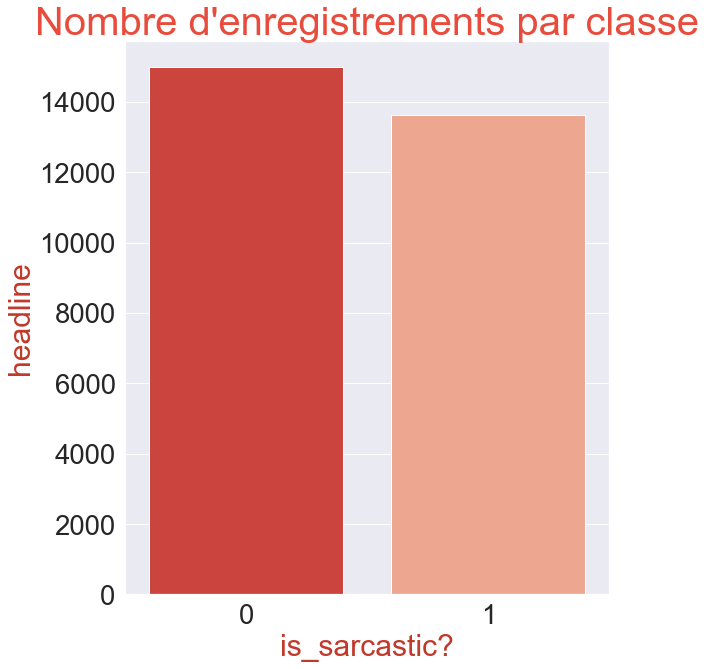

In [169]:
#Visualisation du nombre de speechs par speaker
sns.set(font_scale=2.5)
df=data.groupby('is_sarcastic').count().reset_index()
plt.figure(figsize=(10,10))
sns.barplot(x=df['is_sarcastic'], y=df['headline'], palette="Reds_r")
plt.xlabel('is_sarcastic?', color='#c0392b')
plt.ylabel("headline", color='#c0392b')
plt.title("Nombre d'enregistrements par classe", fontsize=40, color='#e74c3c')
#plt.xticks(rotation= 45)
plt.tight_layout()
plt.savefig('figure2.png')


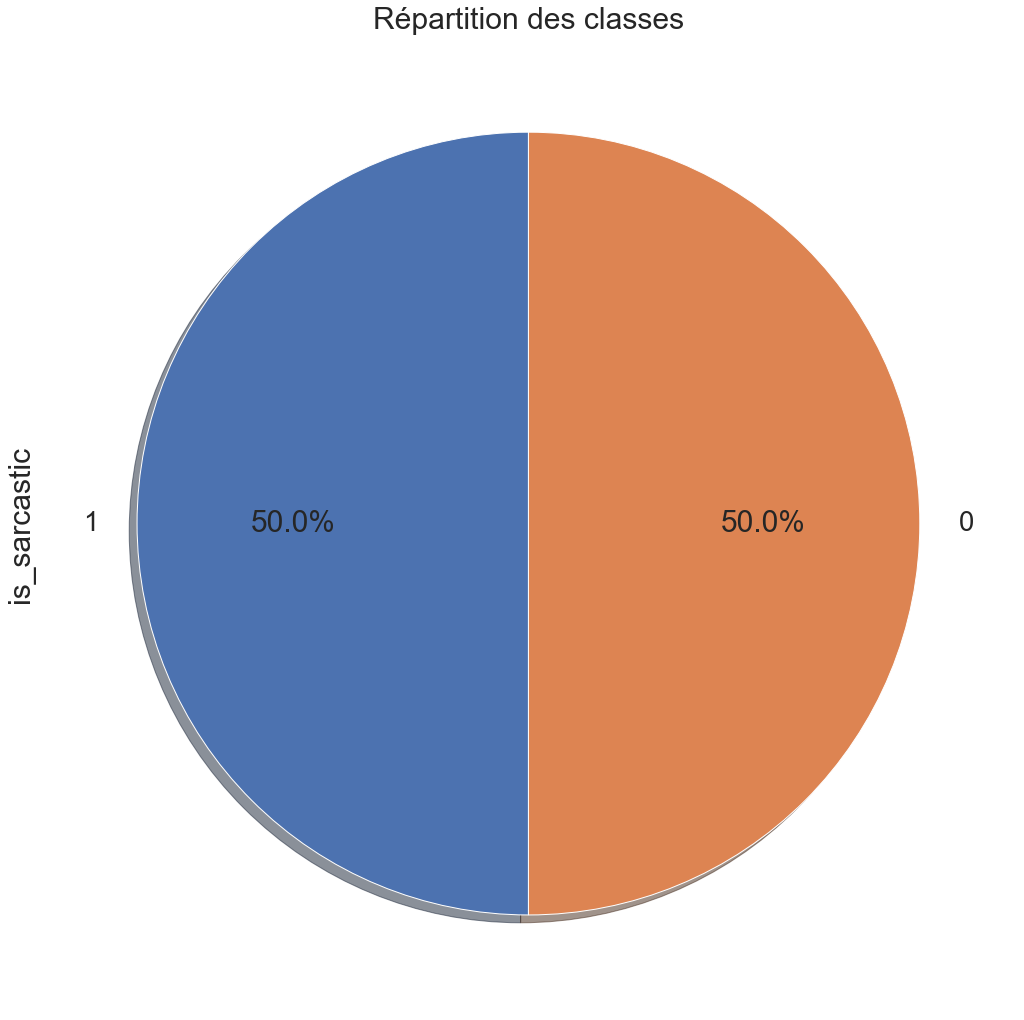

In [142]:
sns.set(font_scale=2.5)
plt.figure(figsize=(20,18))
df.is_sarcastic.value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%',shadow=True,startangle=90)
plt.title('Répartition des classes')
#plt.axis('equal')
plt.savefig('camenbert1.png')
plt.show()

Il n' y a pas de disproportion significative dans la classification'

## 3.4 - Data préprocessing

In [174]:
# data cleaning

#retrait stopwords
stop_words = list(get_stop_words('en'))         

#stop_words = set(stopwords.words('english'))
data['headline']=data['headline'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))


In [175]:
data

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails congress falling short ...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar getting work,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close using word 'streamin...,https://www.theonion.com/mother-comes-pretty-c...
...,...,...,...
28614,1,jews celebrate rosh hashasha something,https://www.theonion.com/jews-to-celebrate-ros...
28615,1,internal affairs investigator disappointed con...,https://local.theonion.com/internal-affairs-in...
28616,0,beautiful acceptance speech week came queer ko...,https://www.huffingtonpost.com/entry/andrew-ah...
28617,1,mars probe destroyed orbiting spielberg-gates ...,https://www.theonion.com/mars-probe-destroyed-...


In [182]:
max_lenght=max([len(s) for s in data.headline])
max_lenght

739

In [184]:

# definitions des  features et du target
array=data.values
X=array[:,1]# features
y=array[:,0]# target
#split train data et test data
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=10)
# prepare le tokenizer
all_reviews=X
t=text.Tokenizer()
t.fit_on_texts(all_reviews)
# On récupère max_length comme étant la longueur de la plus longue headline
max_length = max([len(s.split()) for s in all_reviews])

# On transforme en séquence d'entiers 
x_train_seq=t.texts_to_sequences(X_train)
x_test_seq=t.texts_to_sequences(X_test)
# pad documents to a max length 

x_train_final=sequence.pad_sequences(x_train_seq,max_length,padding='post')
x_test_final=sequence.pad_sequences(x_test_seq, max_length,padding='post')

# definition la taille du vocabulaire, le 1 permet de régler la question de l'index qui démarre à un
vocab_size = len(t.word_index) + 1
print(x_train_final.shape)
y_test

(22895, 107)


array([1, 0, 1, ..., 1, 1, 1], dtype=object)

# Modélisation

Notre modèle  est une classification binaire des sentiments . Pour la modelisation , on va utiliser un RNN ,  qui convient parfaitement pour  ce type de probème.

Chargement du Glove Word Embedding

In [185]:

embeddings_index = dict()
f = open(os.path.join('.', 'glove.6B.100d.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

Loaded 400000 word vectors.


(30803, 100)

## Construction du modèle

In [186]:

e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False)
model = Sequential()
model.add(e)
#model.add(LSTM(32, recurrent_dropout=0.2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['binary_accuracy'])
# summarize the model
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 107, 100)          3080300   
_________________________________________________________________
flatten_10 (Flatten)         (None, 10700)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 10701     
Total params: 3,091,001
Trainable params: 10,701
Non-trainable params: 3,080,300
_________________________________________________________________


In [189]:
# model training
BATCH_SIZE=64
history_glove = model.fit(x_train_final, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=5,
                    verbose=1, 
                    validation_split=0.2)


Train on 18316 samples, validate on 4579 samples
Epoch 1/5
18316/18316 [==============================] - 1s 58us/step - loss: 0.4601 - binary_accuracy: 0.7814 - val_loss: 0.5201 - val_binary_accuracy: 0.7528
Epoch 2/5
18316/18316 [==============================] - 1s 58us/step - loss: 0.4599 - binary_accuracy: 0.7795 - val_loss: 0.5207 - val_binary_accuracy: 0.7547
Epoch 3/5
18316/18316 [==============================] - 1s 58us/step - loss: 0.4599 - binary_accuracy: 0.7822 - val_loss: 0.5211 - val_binary_accuracy: 0.7543
Epoch 4/5
18316/18316 [==============================] - 1s 56us/step - loss: 0.4594 - binary_accuracy: 0.7809 - val_loss: 0.5233 - val_binary_accuracy: 0.7530
Epoch 5/5
18316/18316 [==============================] - 1s 55us/step - loss: 0.4594 - binary_accuracy: 0.7819 - val_loss: 0.5262 - val_binary_accuracy: 0.7526


Test loss: 0.5344883307429313
Test accuracy: 0.7466806173324585


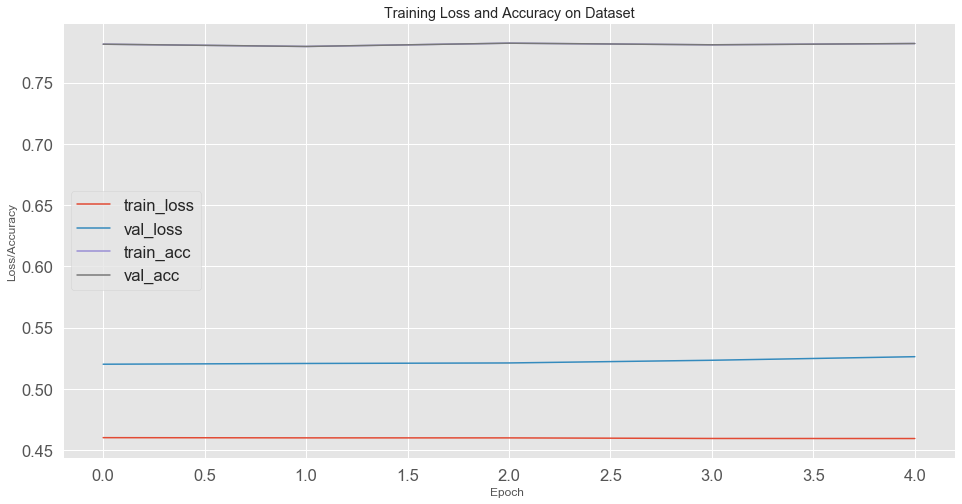

In [190]:
#evaluation du modèle
score = model.evaluate(x_test_final, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# apprentissage
n = np.arange(0, 5)
sns.set(font_scale=1.5)
plt.style.use("ggplot")
plt.figure(figsize=(16,8))
plt.plot(n, history_glove.history["loss"], label="train_loss")
plt.plot(n, history_glove.history["val_loss"], label="val_loss")
plt.plot(n,history_glove.history["binary_accuracy"], label="train_acc")
plt.plot(n,history_glove.history["binary_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch ")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center left")
plt.savefig('training.png')
plt.show()

## Amélioration du modèle

In [191]:


model_pre_trained_2 = Sequential()
model_pre_trained_2.add(e)
model_pre_trained_2.add(Bidirectional(LSTM(64, recurrent_dropout=0.2, return_sequences=True)))
model_pre_trained_2.add(GlobalMaxPooling1D())
model_pre_trained_2.add(Dense(64, activation='relu'))
model_pre_trained_2.add(Dropout(0.2))
model_pre_trained_2.add(Dense(1, activation='sigmoid'))
# compile the model
model_pre_trained_2.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['binary_accuracy'])


# summarize the model
model_pre_trained_2.summary()



Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 107, 100)          3080300   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 107, 128)          84480     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 3,173,101
Trainable params: 92,801
Non-trainable params: 3,080,300
______________________________________

In [194]:
history_pre_trained_2 = model_pre_trained_2.fit(x_train_final, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=20,
                    verbose=1,
                    validation_split=0.2)

Train on 18316 samples, validate on 4579 samples
Epoch 1/20
18316/18316 [==============================] - 59s 3ms/step - loss: 0.2536 - binary_accuracy: 0.8961 - val_loss: 0.4423 - val_binary_accuracy: 0.8080
Epoch 2/20
18316/18316 [==============================] - 58s 3ms/step - loss: 0.2101 - binary_accuracy: 0.9162 - val_loss: 0.4429 - val_binary_accuracy: 0.8142
Epoch 3/20
18316/18316 [==============================] - 57s 3ms/step - loss: 0.1702 - binary_accuracy: 0.9370 - val_loss: 0.5553 - val_binary_accuracy: 0.7877
Epoch 4/20
18316/18316 [==============================] - 57s 3ms/step - loss: 0.1394 - binary_accuracy: 0.9471 - val_loss: 0.4924 - val_binary_accuracy: 0.8187
Epoch 5/20
18316/18316 [==============================] - 57s 3ms/step - loss: 0.1151 - binary_accuracy: 0.9566 - val_loss: 0.5303 - val_binary_accuracy: 0.8152
Epoch 6/20
18316/18316 [==============================] - 56s 3ms/step - loss: 0.0937 - binary_accuracy: 0.9659 - val_loss: 0.6134 - val_binary_ac

In [195]:
score_test = model_pre_trained_2.evaluate(x_test_final, y_test, verbose=0)
score_train=model_pre_trained_2.evaluate(x_train_final, y_train, verbose=0)
print ('Train loss:', score_train[0])
print('Train_accuracy:', score_test[1])
print('Test loss:', score_test[0])
print('Test accuracy:', score_test[1])

Train loss: 0.2051905983339891
Train_accuracy: 0.8100978136062622
Test loss: 1.002865866795026
Test accuracy: 0.8100978136062622


## Sauvegarde de notre modèle

In [196]:
# On sérialise le modèle en JSON
model_serialised = model_pre_trained_2.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_serialised) # On sauve le modèle, plus exactement sa structure, la forme de son squelette
# On sauve les poids
model_pre_trained_2.save_weights("model.h5")
print("Saved model to disk")
 

Saved model to disk


## Réutilisation de notre modèle

In [197]:

from keras.models import model_from_json

# On créé le modèle à partir de la sauvegarde
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# On charge les poids sauvegardés dans le modèle
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
# On peut reprendre le cours de nos activités sans l'entrainement
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(x_test_final, y_test, verbose=0)
print("%s: %.2f" % (loaded_model.metrics_names[0], score[1]))

Loaded model from disk
loss: 0.81


In [198]:
# make class predictions with the model
predictions =  loaded_model.predict_classes(x_test_final)
# summarize the first 5 cases
for i in range(5):
	print('%s => %d (expected %d)' % (X_test[i], predictions[i], y_test[i]))

source jealousy even successful => 1 (expected 1)
historical reenactor gets medieval drone buzzing overhead => 1 (expected 0)
abused 12-year-old alabama girl think can handle mom top everything else => 1 (expected 1)
allegiance white supremacy greater allegiance god? => 0 (expected 0)
dude knit hat party calls beer 'libations' => 1 (expected 1)


Le modèle reussit à trouver  4 prédictions sur 5